In [ ]:
def true_numbers_from_truth(truth):
    """here truth is a single 10 x 10 matrix"""
    num_pos = np.sum(truth > 0)
    num_nonneg = np.sum(truth >= 0)
    num_zero = num_nonneg - num_pos
    # below line definitely wouldn't work for full truth array
    num_neg = truth.size - num_nonneg
    return (num_pos, num_zero, num_neg)

In [ ]:
def strictly_worse_values(value, dist_values, better=None):
    if better is None:
        raise ValueError
    if better.lower() == "higher": # .lower to make things case-insensitive
        return (dist_values < value)
    if better.lower() == "lower": # .lower to make things case-insensitive
        return (dist_values > value)

In [ ]:
def get_exact_tail_probability(value, exact_dist_vals, exact_dist_probs, better=None):
    if better is None:
        raise ValueError
    values_doing_strictly_worse = strictly_worse_values(value, exact_dist_vals, better=better)
    prob_doing_strictly_worse = np.sum(exact_dist_probs[values_doing_strictly_worse])
    prob_doing_strictly_worse = min(1., prob_doing_strictly_worse) # probability greater than 1 is fltng pt. error
    return prob_doing_strictly_worse

In [ ]:
def get_exact_log_score(value, exact_dist_vals, exact_dist_probs, better=None):
    prob_doing_strictly_worse = get_exact_tail_probability(value, exact_dist_vals, exact_dist_probs, better=better)
    log_score = -np.log(1-prob_doing_strictly_worse)/np.log(10) # base 10 log
    return log_score

In [5]:
from simulations.utils import (compute_exact_null_distributions,
                               mixed_sign_Jaccard_similarity,
                               mixed_fdr, mixed_fnr)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product

basically idea seems to be to allocate sum of probability that original Gaussian kernel gave to $-x$ and $+x$ all to $+x$, so that we don't lose probability when cutting off everything beyond $0$.

In [7]:
import scipy
import numpy as np

kde_evaluate = scipy.stats.gaussian_kde.evaluate

def truncated_kde_evaluate(self, x):    
    lb = 0
    ub = 1
        
    if (len(x) == self.d) and (type(x) == list) and (self.d == 2):
        # inside horizontal and vertical boundaries
        val = np.where(((x[0]>=lb)&(x[1]>=lb))&((x[0]<=ub)&(x[1]<=ub)), kde_evaluate(self, x), 0)
        # to left of horizontal boundaries, inside vertical boundaries
        val += np.where(((x[0]>=lb)&(x[1]>=lb))&((x[0]<=ub)&(x[1]<=ub)), kde_evaluate(self, [lb-x[0],x[1]]), 0)
        # inside horizontal boundaries, below vertical boundaries
        val += np.where(((x[0]>=lb)&(x[1]>=lb))&((x[0]<=ub)&(x[1]<=ub)), kde_evaluate(self, [x[0],lb-x[1]]), 0)
        # to left of horizontal boundaries, below vertical boundaries
        val += np.where(((x[0]>=lb)&(x[1]>=lb))&((x[0]<=ub)&(x[1]<=ub)), kde_evaluate(self, [lb-x[0],lb-x[1]]), 0)
        # inside horizontal boundaries, above vertical boundaries
        val += np.where(((x[0]>=lb)&(x[1]>lb))&((x[0]<=ub)&(x[1]<=ub)), kde_evaluate(self, [x[0],ub-(x[1]-ub)]), 0)
        # to right of horizontal boundaries, inside vertical boundaries
        val += np.where(((x[0]>lb)&(x[1]>=lb))&((x[0]<=ub)&(x[1]<=ub)), kde_evaluate(self, [ub-(x[0]-ub),x[1]]), 0)
        # to right of horizontal boundaries, above vertical boundaries
        val += np.where(((x[0]>lb)&(x[1]>lb))&((x[0]<=ub)&(x[1]<=ub)), kde_evaluate(self, [ub-(x[0]-ub),ub-(x[1]-ub)]), 0)
        # to left of horizontal boundaries, above vertical boundaries
        val += np.where(((x[0]>=lb)&(x[1]>lb))&((x[0]<=ub)&(x[1]<=ub)), kde_evaluate(self, [lb-x[0],ub-(x[1]-ub)]), 0)
        # to right of horizontal boundaries, below vertical boundaries
        val += np.where(((x[0]>lb)&(x[1]>=lb))&((x[0]<=ub)&(x[1]<=ub)), kde_evaluate(self, [ub-(x[0]-ub),lb-x[1]]), 0)
    elif self.d == 1:
        val = np.where((x>=lb)&(x<=ub), kde_evaluate(self, x), 0)
        val += np.where((x>=lb)&(x<=ub), kde_evaluate(self, lb-x), 0)
        val += np.where((x>lb)&(x<=ub), kde_evaluate(self, ub-(x-ub)), 0)
    return val

scipy.stats.kde.gaussian_kde.__call__ = truncated_kde_evaluate

The above is an analogous monkey patch for KDE plots.

In [8]:
mode_definitions = [{0:"binary_covariates",1:"count_covariates",2:"log_count_covariates"}, 
                    {0:"scaled",1:"unscaled"},
                    {0:"uncensored",1:"censored"}]
methods_shape = tuple([len(definitions) for definitions in mode_definitions])

In [9]:
truth_dir = 'results'
size = 11
seed = 42
number_droplets = 100000
truth_basename = '{}/{}_strains.seed_{}.{}_droplets.iteration_{{}}.npz'.format(truth_dir, size, seed, number_droplets)

results_dir = 'phenopath_results/{}/{}' # covariate type, scale type
results_basename = '{}/iteration_{{}}.npz'.format(results_dir)

In [10]:
number_iterations = 100

mix_jaccard_tail_probs = np.zeros((*methods_shape,number_iterations))
pos_jaccard_tail_probs = np.zeros((*methods_shape,number_iterations))
neg_jaccard_tail_probs = np.zeros((*methods_shape,number_iterations))
mix_fnr_tail_probs = np.zeros((*methods_shape,number_iterations))
pos_fnr_tail_probs = np.zeros((*methods_shape,number_iterations))
neg_fnr_tail_probs = np.zeros((*methods_shape,number_iterations))
mix_fdr_tail_probs = np.zeros((*methods_shape,number_iterations))
pos_fdr_tail_probs = np.zeros((*methods_shape,number_iterations))
neg_fdr_tail_probs = np.zeros((*methods_shape,number_iterations))

In [11]:
for iteration_number in range(number_iterations):

    truth_npzfile = np.load(truth_basename.format(iteration_number+1))
    truth = truth_npzfile['truth'][0:-1,0:-1]
    true_numbers = true_numbers_from_truth(truth)
    exact_null_distributions = compute_exact_null_distributions(true_numbers)
    
    for covariate_type, scale_choice, censor_choice in product(*[range(i) for i in methods_shape]):
        multiindex = (covariate_type, scale_choice, censor_choice)
        
        phenopath_npzfile = np.load(results_basename.format(mode_definitions[0][covariate_type], 
                                                            mode_definitions[1][scale_choice], 
                                                            iteration_number+1))
        estimate = phenopath_npzfile['{}_results'.format(mode_definitions[2][censor_choice])][0:-1,0:-1]

        results = {}
        results['mixed_jaccard'] = mixed_sign_Jaccard_similarity(truth, estimate)
        results['pos_jaccard'] = mixed_sign_Jaccard_similarity(truth, estimate, positive_part=True)
        results['neg_jaccard'] = mixed_sign_Jaccard_similarity(truth, estimate, negative_part=True)
        results['mixed_fdr'] = mixed_fdr(truth, estimate)
        results['pos_fdr'] = mixed_fdr(truth, estimate, positive_part=True)
        results['neg_fdr'] = mixed_fdr(truth, estimate, negative_part=True)
        results['mixed_fnr'] = mixed_fnr(truth, estimate)
        results['pos_fnr'] = mixed_fnr(truth, estimate, positive_part=True)
        results['neg_fnr'] = mixed_fnr(truth, estimate, negative_part=True)

        mix_jaccard_tail_probs[(*multiindex, iteration_number)] = get_exact_tail_probability(results['mixed_jaccard'], *exact_null_distributions['mixed_jaccard'], better="higher")
        pos_jaccard_tail_probs[(*multiindex, iteration_number)] = get_exact_tail_probability(results['pos_jaccard'], *exact_null_distributions['pos_jaccard'], better="higher")
        neg_jaccard_tail_probs[(*multiindex, iteration_number)] = get_exact_tail_probability(results['neg_jaccard'], *exact_null_distributions['neg_jaccard'], better="higher")
        mix_fdr_tail_probs[(*multiindex, iteration_number)] = get_exact_tail_probability(results['mixed_fdr'], *exact_null_distributions['mixed_fdr'], better="Lower")
        pos_fdr_tail_probs[(*multiindex, iteration_number)] = get_exact_tail_probability(results['pos_fdr'], *exact_null_distributions['pos_fdr'], better="lower")
        neg_fdr_tail_probs[(*multiindex, iteration_number)] = get_exact_tail_probability(results['neg_fdr'], *exact_null_distributions['neg_fdr'], better="lower")
        mix_fnr_tail_probs[(*multiindex, iteration_number)] = get_exact_tail_probability(results['mixed_fnr'], *exact_null_distributions['mixed_fnr'], better="lower")
        pos_fnr_tail_probs[(*multiindex, iteration_number)] = get_exact_tail_probability(results['pos_fnr'], *exact_null_distributions['pos_fnr'], better="lower")
        neg_fnr_tail_probs[(*multiindex, iteration_number)] = get_exact_tail_probability(results['neg_fnr'], *exact_null_distributions['neg_fnr'], better="lower")

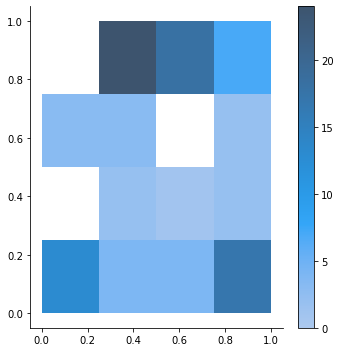

In [21]:
sns.displot(x=neg_fdr_tail_probs[2,0,0,:], y=neg_fnr_tail_probs[2,0,0,:], cbar=True, binwidth=(.25, .25))

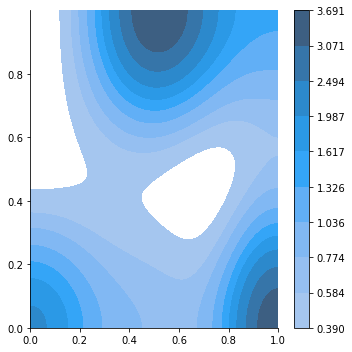

In [22]:
sns.displot(x=neg_fdr_tail_probs[2,0,0,:], y=neg_fnr_tail_probs[2,0,0,:], cbar=True, cut=0, fill=True, kind="kde")

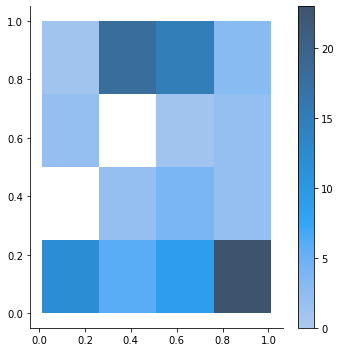

In [23]:
sns.displot(x=pos_fdr_tail_probs[2,0,0,:], y=pos_fnr_tail_probs[2,0,0,:], cbar=True, binwidth=(.25, .25))

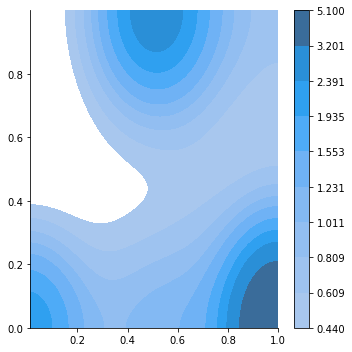

In [24]:
sns.displot(x=pos_fdr_tail_probs[2,0,0,:], y=pos_fnr_tail_probs[2,0,0,:], cbar=True, cut=0, kind="kde", fill=True)

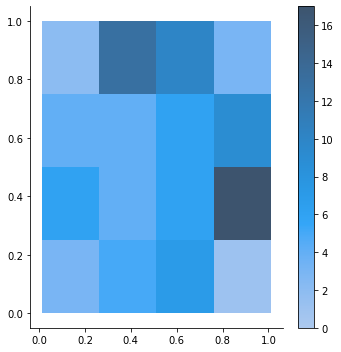

In [25]:
sns.displot(x=pos_fdr_tail_probs[2,0,0,:], y=neg_fdr_tail_probs[2,0,0,:], cbar=True, binwidth=(.25, .25))

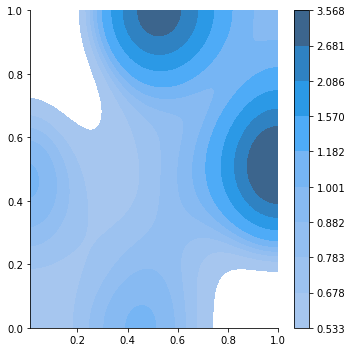

In [26]:
sns.displot(x=pos_fdr_tail_probs[2,0,0,:], y=neg_fdr_tail_probs[2,0,0,:], cbar=True, cut=0, kind="kde", fill=True)

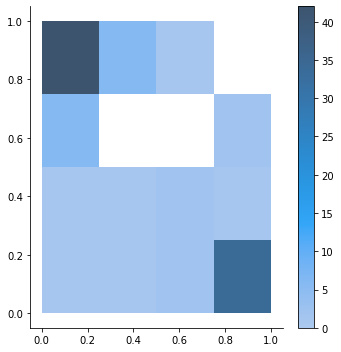

In [27]:
sns.displot(x=pos_fnr_tail_probs[2,0,0,:], y=neg_fnr_tail_probs[2,0,0,:], cbar=True, binwidth=(.25, .25))

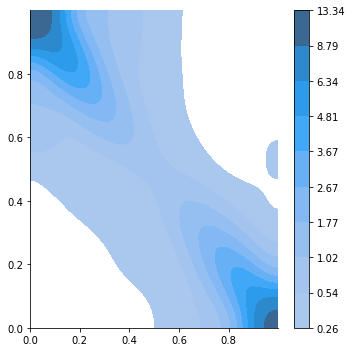

In [28]:
sns.displot(x=pos_fnr_tail_probs[2,0,0,:], y=neg_fnr_tail_probs[2,0,0,:], cbar=True, cut=0, kind="kde", fill=True)

In [29]:
np.savez_compressed('phenopath_tail_probs.npz',
                   mix_jaccard=mix_jaccard_tail_probs,
                   pos_jaccard=pos_jaccard_tail_probs,
                   neg_jaccard=neg_jaccard_tail_probs,
                   mix_fdr=mix_fdr_tail_probs,
                   pos_fdr=pos_fdr_tail_probs,
                   neg_fdr=neg_fdr_tail_probs,
                   mix_fnr=mix_fnr_tail_probs,
                   pos_fnr=pos_fnr_tail_probs,
                   neg_fnr=neg_fnr_tail_probs)